In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [7]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar):
    Ncut = 601
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas):
    Ncut = np.shape(Omegas)[0]
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbars[0])
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbars[1])
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbars[2])*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return (1.0/(nbar+1))*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [15]:
def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

In [36]:
def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0s, nbars, Omegas):
    Omega01 = Omega0s[0]
    Omega02 = Omega0s[1]
    Omega03 = Omega0s[2]
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = freeEvo@therm3DPulse(psi0, t1, Omega01, delPrime, nbars, Omegas)
    resultP = therm3DPulse(therm3DPulse(pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas), t2/3.0, Omega03, delPrime, nbars, Omegas)
    resultM = therm3DPulse(therm3DPulse(pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas), t2/3.0, Omega03, delPrime, nbars, Omegas)
    return rhoee(resultP) - rhoee(resultM)

In [41]:
pts = 200
ts = np.linspace(0.0,20.0, pts)
rhoDDs = np.zeros(pts)
rhoDDbs = np.zeros(pts)
rhoDDcs = np.zeros(pts)
Ncut = 201
Omega0 = np.pi
eta = 0.1
nbar = 10.0
x = nbar/(nbar+1.0)

for ii in range(pts):
    rhoDDbs[ii] = 0.5*(1 - (np.cos(2.0*Omega0*ts[ii])*(1.0-x*np.cos(2.0*Omega0*ts[ii]*eta**2)) + x*np.sin(2.0*Omega0*ts[ii]) \
        *np.sin(2.0*Omega0*ts[ii]*eta**2))/((nbar+1.0)*(1.0+ x**2 -2.0*x*np.cos(2.0*Omega0*ts[ii]*eta**2))))
    
    rhoDDcs[ii] = 0.5*(1.0 - (np.cos(2.0*Omega0*ts[ii]) + 2.0*Omega0*ts[ii]*(eta**2)*nbar*np.sin(2.0*Omega0*ts[ii])) \
        /(1.0 + (nbar*2.0*Omega0*ts[ii]*eta**2)**2))
    for n in range(Ncut):
        rhoDDs[ii] += prob(n, nbar)*(np.sin(Omega0*Omega(n,0,eta)*ts[ii]))**2

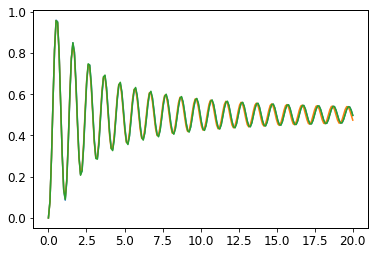

In [42]:
plt.plot(ts,rhoDDs )
plt.plot(ts,rhoDDbs)
plt.plot(ts,rhoDDcs)

(-0.05, 0.05)

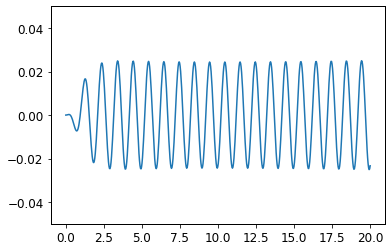

In [33]:
plt.plot(ts,rhoDDbs-rhoDDs)
plt.ylim([-0.05, 0.05])

(0.005, -0.005)

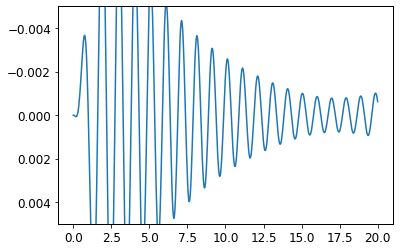

In [34]:
plt.plot(ts, rhoDDcs-rhoDDs)
plt.ylim([5e-3, -5e-3])

In [8]:
nbarx = 10.0
nbary = 5.0
nbarz = 5.0
Ncut = 51
etax = 0.05
etay = 0.05
etaz = 0.05
ts = np.linspace(0.0,5.0,20)
rhoDD = np.zeros(np.size(ts))
rhoDD2 = np.zeros(np.size(ts))
rhoDD3 = np.zeros(np.size(ts))
psi0 = psi(1.0,0.0)

Omegas = np.zeros((Ncut,Ncut,Ncut))
for nx in range(Ncut):
    print(nx)
    for ny in range(Ncut):
        for nz in range(Ncut):
            Omegas[nx,ny,nz] = Omega(nx,0,etax)*Omega(ny,0,etay)*Omega(nz,0,etaz)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [9]:
Ncut = 101
Omega1s = np.zeros((Ncut,Ncut,Ncut))
for nx in range(Ncut):
    print(nx)
    for ny in range(Ncut):
        for nz in range(Ncut):
            Omega1s[nx,ny,nz] = Omega(nx,0,etax)*Omega(ny,0,etay)*Omega(nz,0,etaz)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [13]:
#therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
pts = 20
ts = np.linspace(0.0, 5.0, pts)
rhoDDs = np.zeros(pts)
rhoDD1s = np.zeros(pts)
psi0 = psi(1.0,0.0)
Omega0 = np.pi
nbars = np.array([10.0, 5.0, 5.0])

for ii in range(pts):
    print(ii)
    rhoDDs[ii] = rhoee(therm3DPulse(psi0, ts[ii], Omega0, 0.0, nbars, Omegas))
    rhoDD1s[ii] = rhoee(therm3DPulse(psi0, ts[ii], Omega0, 0.0, nbars, Omega1s))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


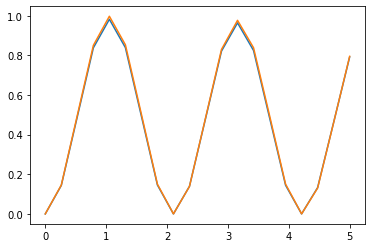

In [14]:
plt.plot(ts, rhoDDs)
plt.plot(ts, rhoDD1s)

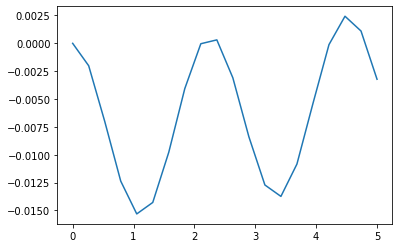

In [15]:
plt.plot(ts, rhoDDs-rhoDD1s)

In [39]:
#HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0s, nbars, Omegas)
psi0 = psi(0.0, 1.0)
Omega01 = 50.0*(2.0*np.pi) #5 kHz
Delta = 1.0*(2.0*np.pi) #Hz
t1 = np.pi/(2.0*Omega01)
T = 20.0/Omega01
t2 = 3.0*np.pi/(2.0*Omega01)
Omega0s = np.array([1.0,1.0,1.0])
nbars = np.array([10.0,5.0,5.0])

sp.optimize.root_scalar(HRJumpThermErrSig,args=(psi0, t1, T, t2, Delta, Omega0s, nbars, Omega1s), bracket=[0.,0.05], xtol = 1e-8).root

0.028008939176923278

In [18]:
psi0 = psi(1.0, 0.0)
pts = 15
rhos = np.zeros(pts)
nbars = np.linspace(0,150,pts)
for ii in range(pts):
    rhos[ii] = rhoee(thermPulse(psi0, np.pi/2.0, 1.0, 0.0, 0.05, nbars[ii]))

TypeError: thermPulse() missing 5 required positional arguments: 't', 'Omega0', 'delPrime', 'eta', and 'nbar'

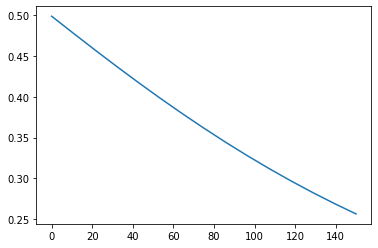

In [12]:
plt.plot(nbars, rhos)

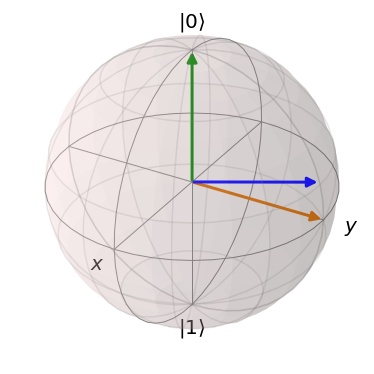

In [20]:
psi1 = thermPulse(psi0, np.pi/2.0, 1.0, 0.0, 0.0, 0.0)
psi2 = thermPulse(psi0, np.pi/2.0, 1.0, 0.0, 0.05, 80.0)

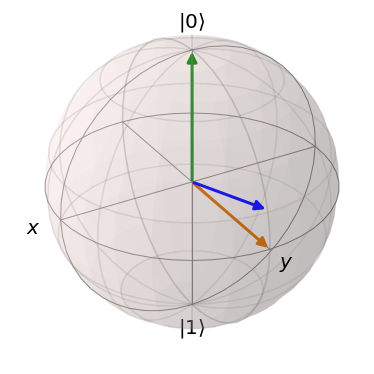

In [24]:
b = Bloch()
b.add_vectors(blochVec(psi0))
b.add_vectors(blochVec(psi1))
b.add_vectors(blochVec(psi2))
b.view = [-30, 30]
b.show()